### Neighborhood Reconstruction Methods (chapter 3 of book)

#### Encoder-Decoder

- The goal is to learn (graph) node embeddings, which encode the nodes as low-dimensional vectors, capturing the nodes graph position and their neighborhood structure.
- Nodes are projected into a latent/hidden space, where geometric relationships between the embeddings correspond to the relationships in the original graph.
- Node embedding can be approached with the _encoding-decoding_ framework.
- This is an example of "graph representation learning": the act of learning a representation of the graph.
- Two operations in this learning process are the _encoder_ (mapping nodes to vectors), and the _decoder_, which reconstruct information about the original nodes based on the vector embeddings (this is vague, but will be made precise).
- Example of shallow embedding as encoder: $ENC: V \to \mathbb{R}^d$. Notation: $ENC(v) = z_v$. 
    - The encoder is a lookup function: $ENC(v) = Z[v]$, where $Z \in \mathbb{R}^{|V|\times d}$, a matrix with all the embeddings as rows, and $Z[v]$ denoting the row corresponding to $v \in V$.
    - More general encoders use information about the graph, beyond the node id, for example node features or local graph structure.
- The decoder aims to recover graph information based on the embeddings.
- Example: pairwise decoder: $DEC: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$, aiming to recover the similarity between nodes based on the corresponding embeddings.
- Optimize (learn) ENC, DEC so that: $$ DEC(ENC(u), ENC(v)) = DEC(z_u, z_v) \approx S(u,v)$$ where $S(u,v)$ is a similarity defined on pairs of graph nodes.
- Some examples of Similarities:
    - $S(u,v) = A(u,v)$, where $A$ is the adjacency matrix.
    - $S(u,v) = \frac{|N(u)\cap N(v)|}{|N(u)\cup N(v)|}$.
    - $S(u,v) = \sum_{w \in N(u)\cap N(v)} \frac{1}{d_w}$.

#### Optimizing an Encoder-Decoder Model
- To train $ENC$ to obtain $DEC(ENC(u), ENC(v)) = DEC(z_u, z_v) \approx S(u,v)$, we do loss minimization. 
- Minimize $$\mathscr{L} = \sum_{(u,v) \in D} l(DEC(z_u, z_v), S(u,v))$$ over the training nodes $D$.
- What determines an approach is the choice of: (1) loss $l$, (2) node similarity, (3) decoder $DEC:\mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$.
- For example:
    - Any of the 3 similarities above.
    - Decoder: $DEC(z_u, z_v) = z_u^Tz_v$.
    - Loss: $l(DEC(z_u, z_v), S(u,v)) = ||DEC(z_u, z_v) - S(u,v)||_2^2$. 




#### Little experiement
- generates an Erdős–Rényi graph,
- builds the Jaccard similarity matrix,
- picks a small embedding dimension $d$ via a simple SVD energy heuristic,
- learns node embeddings on CPU with PyTorch,
- uses a cosine-based decoder with learnable affine calibration to keep outputs in $[0,1]$.
- excludes self-pairs from training,
- adds light regularization and norm control,
- prints quick diagnostics (RMSE + Spearman) and, if $d \in \{2,3\}$, plots the embedding.

In [92]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable

        

In [93]:


# =============================
# Graph Embedding (Jaccard target) with Cosine Decoder and Unit-Norm Embeddings
# =============================

# ---------- Reproducibility ----------
seed = None # fixed seed at an int ti make runs repeatable or None for random runs
if seed is not None:
    np.random.seed(seed)
    torch.manual_seed(seed)


# ---------- Graph: ER generator (adjacency, no self-loops) ----------
def generate_symmetric_adj(N, p, seed=None):
    """Generate an undirected Erdős–Rényi adjacency (N x N), no self-loops."""
    U = np.random.rand(N, N)      # generate random matrix
    A = np.triu((U < p).astype(float), 1)     # sample upper triangle only; avoid double-counting
    A = A + A.T                               # symmetrize to get undirected graph
    return torch.tensor(A, dtype=torch.float32)


# ---------- Jaccard similarity on adjacency ----------
def jaccard_similarity(A, include_diag=False):
    """
    Jaccard(u,v) = |N(u) ∩ N(v)| / |N(u) ∪ N(v)| using common-neighbor algebra.
    Works on the binary adjacency (no self-loops).
    """
    deg = A.sum(dim=1)                         # degree for each node (size of neighborhood)
    inter = A @ A                              # common neighbors count for each (u,v)
    union = deg.unsqueeze(1) + deg.unsqueeze(0) - inter
    union = torch.where(union > 0, union, torch.ones_like(union))  # prevent division by 0 for isolated pairs
    S = inter / union                          # Jaccard is in [0,1]
    if include_diag:                            # by definition, S(u,u)=1 when deg(u)>0; keep it for evaluation tables
        S.fill_diagonal_(1.0)
    else:                                       # for training you may want to ignore the trivial diagonal signal
        S.fill_diagonal_(0.0)
    return S


# ---------- Heuristic for embedding dimension ----------
def pick_embedding_dimension(S, target_energy=0.80, dmin=2, dmax=16):
    """
    Pick smallest d whose top-d singular values explain >= target_energy of ||S||_F^2.
    Keeps d small for interpretability/efficiency, but large enough to capture main variation.
    """
    S_centered = S - S.mean()                  # centering emphasizes relational deviations over absolute level
    _, sv, _ = torch.linalg.svd(S_centered, full_matrices=False)
    cum = (sv**2).cumsum(0)
    frac = cum / cum[-1]                       # cumulative energy fraction
    d = int((frac < target_energy).sum().item() + 1)  # first index crossing the target
    return max(dmin, min(d, dmax, S.shape[0])) # clamp to [dmin, min(dmax, N)]


# ---------- Cosine decoder model with unit-norm projection ----------
class CosineDecoder(nn.Module):
    """
    Minimal encoder/decoder:
      - Parameters: unconstrained embedding table W in R^{N x d}
      - Forward: project rows to unit sphere => Z, then cosine(Z[u], Z[v]).
    Rationale:
      - Unit-norm constraint ensures self-similarity equals to 1.
      - Cosine is bounded [-1,1], so MSE vs Jaccard (in [0,1]) is numerically stable.
    """
    def __init__(self, num_nodes, dim):
        super().__init__()
        self.W = nn.Embedding(num_nodes, dim)               # unconstrained parameters
        nn.init.normal_(self.W.weight, std=1.0 / np.sqrt(dim))  # small init keeps early training stable

    def forward(self, u_idx, v_idx):
        Z = self.normalized_weight()                        # always use unit-norm embeddings in the decoder
        z_u = Z[u_idx]                                      # (B, d) views into normalized table
        z_v = Z[v_idx]
        return (z_u * z_v).sum(dim=1)                       # cosine because each row has norm 1

    def normalized_weight(self):
        # Deterministic projection: row-wise normalize without altering underlying params.
        W = self.W.weight
        return W / (W.norm(dim=1, keepdim=True) + 1e-8)

    def project_inplace_(self):
        # Hard projection step: overwrite W with its normalized version after optimizer step.
        with torch.no_grad():
            self.W.weight.copy_(self.normalized_weight())


# ---------- Training primitive ----------
def build_offdiag_pairs(N):
    """Return index pairs (u,v) with u != v to focus learning on cross-node relationships."""
    u, v = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    m = (u != v)
    return u[m].reshape(-1), v[m].reshape(-1)


def train(model, S, lr=5e-3, weight_decay=1e-4, epochs=3000, proj_every=1):
    """
    Train to minimize MSE between cosine(model(u,v)) and Jaccard S[u,v] on off-diagonal pairs.
    - Unit-norm enforced via post-step projection (proj_every).
    - Weight decay nudges parameters toward smaller norm (even though we project for decoding).
    """
    N = S.shape[0]
    u_pairs, v_pairs = build_offdiag_pairs(N)   # exclude diagonal so loss isn't dominated by trivial self=1
    y = S[u_pairs, v_pairs]                     # target Jaccard for those pairs
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_hist = []

    for t in range(1, epochs + 1):
        opt.zero_grad()
        pred = model(u_pairs, v_pairs)          # cosine similarity in [-1,1]
        loss = ((pred - y) ** 2).mean()         # MSE aligns the cosine to nonnegative Jaccard values
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # protect from rare spikes when graphs are tiny
        opt.step()

        if (t % proj_every) == 0:               # enforce unit-norm rows so cos(u,u)=1 always holds
            model.project_inplace_()

        loss_hist.append(loss.item())
    return loss_hist


# ---------- Visualization helpers ----------
def plot_learning_curve(loss_hist):
    """First deliverable: learning curve to confirm optimization behaves."""
    plt.figure(figsize=(5,3))
    plt.plot(loss_hist, lw=2)
    plt.xlabel("Step"); plt.ylabel("MSE (off-diagonal)")
    plt.title("Training Loss vs. Steps")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def print_reconstruction_table(model, A, header="Pairwise reconstruction"):
    """
    Print (u,v) | True Jaccard | Estimated Cosine.
    """
    N = A.shape[0]
    # if N >= 6:
    #     return
    print(f"\n{header}:")
    S_full = jaccard_similarity(A, include_diag=True)       # keep diagonal = 1 for fair comparison
    with torch.no_grad():
        Z = model.normalized_weight()                       # ensure we're using unit-norm embeddings
        for u in range(N):
            for v in range(N):
                est = (Z[u] * Z[v]).sum().item()            # cosine(u,v); equals 1.0 when u==v
                tru = S_full[u, v].item()                   # Jaccard(u,v)
                print(f"({u},{v})  True={tru:.3f}  Est={est:.3f}")


def plot_graph_and_embeddings(A, model, d, jitter=0.1, layout="circle"):
    """
    One-shot view: left = graph, right = embeddings (2D/3D or PCA to 2D if d>3).
    - Builds G from adjacency A.
    - Uses circle layout by default for consistent, tidy graphs.
    """
    # Build graph from adjacency
    adj = A.detach().cpu().numpy()
    N = adj.shape[0]
    G = nx.from_numpy_array(adj)

    # Choose graph layout
    if layout == "circle":
        pos = nx.circular_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)

    # Get unit-norm embeddings
    with torch.no_grad():
        Z = model.normalized_weight().cpu().numpy()

    if d == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10,5))

        # --- Graph (left) ---
        nx.draw(G, pos, ax=axes[0], with_labels=True, node_size=400, font_size=8)
        axes[0].set_title("Graph (circle layout)" if layout=="circle" else "Graph")

        # --- Embeddings (right) ---
        axes[1].scatter(Z[:,0], Z[:,1], s=60)
        for i in range(N):
            axes[1].text(Z[i,0] + jitter*np.random.uniform(-1,1),
                         Z[i,1] + jitter*np.random.uniform(-1,1),
                         str(i), fontsize=9)
        axes[1].set_title("2D embeddings (unit-norm)")
        axes[1].axis("equal"); axes[1].grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()

    elif d == 3:
        fig = plt.figure(figsize=(10,5))

        # --- Graph (left) ---
        ax1 = fig.add_subplot(121)
        nx.draw(G, pos, ax=ax1, with_labels=True, node_size=400, font_size=8)
        ax1.set_title("Graph (circle layout)" if layout=="circle" else "Graph")

        # --- Embeddings (right) ---
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(Z[:,0], Z[:,1], Z[:,2], s=40)
        for i in range(N):
            ax2.text(Z[i,0] + jitter*np.random.uniform(-1,1),
                     Z[i,1] + jitter*np.random.uniform(-1,1),
                     Z[i,2] + jitter*np.random.uniform(-1,1),
                     str(i), fontsize=8)
        ax2.set_title("3D embeddings (unit-norm)")

        plt.tight_layout(); plt.show()

    else:
        # PCA projection to 2D when d>3
        Z_proj = PCA(n_components=2).fit_transform(Z)

        fig, axes = plt.subplots(1, 2, figsize=(10,5))

        # --- Graph (left) ---
        nx.draw(G, pos, ax=axes[0], with_labels=True, node_size=400, font_size=8)
        axes[0].set_title("Graph (circle layout)" if layout=="circle" else "Graph")

        # --- PCA embeddings (right) ---
        axes[1].scatter(Z_proj[:,0], Z_proj[:,1], s=60)
        for i in range(N):
            axes[1].text(Z_proj[i,0] + jitter*np.random.uniform(-1,1),
                         Z_proj[i,1] + jitter*np.random.uniform(-1,1),
                         str(i), fontsize=9)
        axes[1].set_title(f"PCA projection of {d}D embeddings")
        axes[1].axis("equal"); axes[1].grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()


Selected embedding dimension d = 3


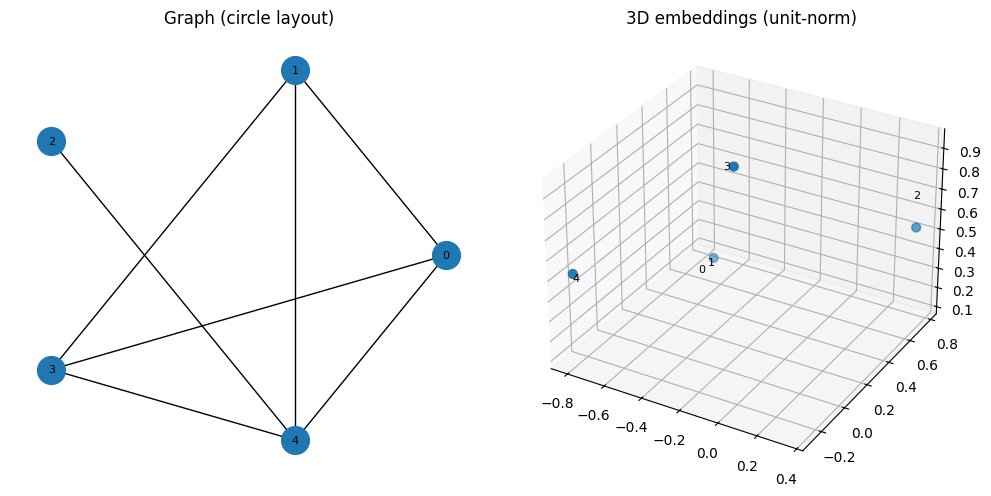

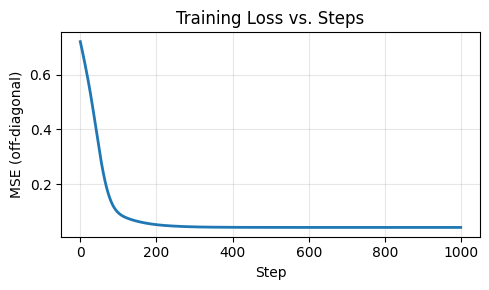


Pairwise similarity: Jaccard (True) vs Cosine (Estimated):
(0,0)  True=1.000  Est=1.000
(0,1)  True=0.500  Est=1.000
(0,2)  True=0.333  Est=0.366
(0,3)  True=0.500  Est=0.463
(0,4)  True=0.400  Est=0.435
(1,0)  True=0.500  Est=1.000
(1,1)  True=1.000  Est=1.000
(1,2)  True=0.333  Est=0.365
(1,3)  True=0.500  Est=0.464
(1,4)  True=0.400  Est=0.437
(2,0)  True=0.333  Est=0.366
(2,1)  True=0.333  Est=0.365
(2,2)  True=1.000  Est=1.000
(2,3)  True=0.333  Est=0.562
(2,4)  True=0.000  Est=-0.223
(3,0)  True=0.500  Est=0.463
(3,1)  True=0.500  Est=0.464
(3,2)  True=0.333  Est=0.562
(3,3)  True=1.000  Est=1.000
(3,4)  True=0.400  Est=0.653
(4,0)  True=0.400  Est=0.435
(4,1)  True=0.400  Est=0.437
(4,2)  True=0.000  Est=-0.223
(4,3)  True=0.400  Est=0.653
(4,4)  True=1.000  Est=1.000


In [94]:


# ---- Minimal knobs to tune experiments ----
N = 5                      # try very small (e.g., 5) to see the reconstruction table
p = 0.40                    # ER edge probability; larger p => more triangles => richer Jaccard
epochs = 1000               # more steps give tighter fit on small graphs
lr = 5e-3                   # conservative LR works well with unit-norm projection
target_energy = 0.90        # controls selected embedding dimension via SVD
weight_decay = 1e-4         # mild regularization; stable on tiny graphs


# ---- 1) Generate Graph ----
A = generate_symmetric_adj(N, p, seed=seed)             # sample a random ER graph
#G = visualize_graph_circle(A, p)                            # quick visual sanity check

# ---- 2) Similarity ----
S_train = jaccard_similarity(A, include_diag=False)     # drop diagonal in training to focus on structure

# ---- 3) Pick a small d ----
d = pick_embedding_dimension(S_train, target_energy=target_energy)
print(f"Selected embedding dimension d = {d}")

# ---- 4) Model + Train ----
model = CosineDecoder(num_nodes=N, dim=d)               # cosine decoder; self=1 when u==u
loss_hist = train(model, S_train, lr=lr,
                    weight_decay=weight_decay, epochs=epochs, proj_every=1)

# ---- 5) Plots ----
plot_graph_and_embeddings(A, model, d, jitter=0.1, layout="circle")


# ---- 5) Results: learning curve then reconstruction table ----
plot_learning_curve(loss_hist)                          # (1) learning curve first
print_reconstruction_table(model, A, header="Pairwise similarity: Jaccard (True) vs Cosine (Estimated)")


